In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi
import plotly.express as px
import seaborn as sns

In [2]:
# Connect to data base
import mysql.connector as mysql
from mysql.connector import Error
try:
    db = mysql.connect(
        host = "localhost",
        database='mestradoNOTA',
        user = "root",
        passwd = "admin123"
    )
    
    if db.is_connected():
        cursor = db.cursor(buffered=True)
#         cursor = db.cursor()
except Error as e:
    print("Error while connecting to MySQL", e)


In [40]:
# whereClause = " name='ALGORITMOS E PROGRAMACAO DE COMPUTADORES' "
whereClause = " name='INTRODUCAO A CIENCIA DA COMPUTACAO' "
where1 = " and gender = 'M' "
whereCourses = " and (course <> 'Computacao' and course <> 'Ciencia da Computacao' and course <> 'Engenharia de Computacao' and course <> 'Engenharia Mecatronica') "
# where1 = " and gender = 'F' and course = 'Engenharia Florestal'"
# where1 = " and gender = 'F' and course = 'Computacao'"
# whereClause = " (name = 'ALGORITMOS E PROGRAMACAO DE COMPUTADORES' OR name = 'COMPUTACAO BASICA' OR name = 'INTRODUCAO A CIENCIA DA COMPUTACAO')"

# Qual a quantidade de aprovações/reprovações na matéria

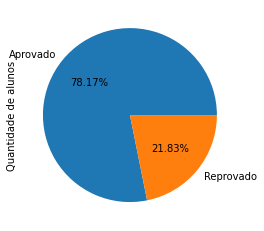

In [95]:
select_query = "select SUM(CASE WHEN num_score > 2 THEN 1 ELSE 0 END) as Aprovado, SUM(CASE WHEN num_score < 3 THEN 1 ELSE 0 END) as Reprovado, count(*) as Total from students as S INNER JOIN student_course_subject as SCS ON S.id = SCS.id_student INNER JOIN subjects as Sub ON Sub.id = SCS.id_subject INNER JOIN student_courses as SC ON SC.id_student = S.id where" + whereClause + where1

cursor.execute(select_query)
records = pd.DataFrame(cursor.fetchall())
records.columns = cursor.column_names
series = pd.Series([pd.to_numeric(records['Aprovado']).tolist()[0], pd.to_numeric(records['Reprovado']).tolist()[0]], index=["Aprovado", "Reprovado"], name="Quantidade de alunos")

series.plot.pie(autopct="%.2f%%",);

# Quais os cursos dos alunos fizeram pela primeira vez a matéria em comparação com os que fazem novamente?

In [41]:
select_query = "select SC.id_student as id_student, course as curso, num_score as nota from students as St INNER JOIN student_courses as SC on SC.id_student=St.id INNER JOIN student_course_subject as SCS on St.id = SCS.id_student INNER JOIN subjects as S on S.id = SCS.id_subject  where " + whereClause + where1 + whereCourses + "order by id_student, semester_year"
cursor.execute(select_query)
records = pd.DataFrame(cursor.fetchall())
records.columns = cursor.column_names

firstTime = pd.DataFrame(columns = cursor.column_names)
nextTime = pd.DataFrame(columns = cursor.column_names)
id_student = records['id_student'].unique().tolist()

count = 0
for i in id_student:

    firstTime.loc[count] = records[records['id_student']==i].iloc[0]
    count = count + 1;

for i in id_student:
    nextTime= pd.concat([nextTime, records[records['id_student']==i][1:]])


In [42]:
del firstTime["id_student"]
firstTime['nota'] = pd.to_numeric(firstTime['nota'])
firstTime['vez'] = 'primeira vez'

del nextTime["id_student"]
nextTime['nota'] = pd.to_numeric(nextTime['nota'])
nextTime['vez'] = 'multiplas vezes'

In [43]:
firstTimeGroup = firstTime.groupby(['curso']).mean()
nextTimeGroup = nextTime.groupby(['curso']).mean()

firstTimeGroupStd = firstTime.groupby(['curso']).std()
nextTimeGroupStd = nextTime.groupby(['curso']).std()
join = pd.concat([firstTime, nextTime])

In [44]:
course = records['curso'].unique().tolist()
simpleList = []
for i in course:
    total_primeira_vez = firstTime[firstTime['curso'] == i]['curso'].count()
    total_mais_uma_vez = nextTime[nextTime['curso'] == i]['curso'].count()
    try:
        media_primeira_vez = firstTimeGroup.loc[i]['nota']
        std_primeira_vez = firstTimeGroupStd.loc[i]['nota']
    except:
        media_primeira_vez = 0
        std_primeira_vez = 0
    try:
        media_mais_uma_vez = nextTimeGroup.loc[i]['nota']
        std_mais_uma_vez = nextTimeGroupStd.loc[i]['nota']
        
    except:
        media_mais_uma_vez = 0
        std_mais_uma_vez = 0
        
    simpleList.append([total_primeira_vez, total_mais_uma_vez, media_primeira_vez, media_mais_uma_vez, std_primeira_vez, std_mais_uma_vez])

plotdata = pd.DataFrame(simpleList,
                        columns=['total primeira vez', 'total multiplas vezes', 'média primeira vez', 'média multiplas vezes', 'std_primeira_vez', 'std_mais_uma_vez'],
                        index = course)
plotdata = plotdata.sort_index()

<AxesSubplot:ylabel='nota dos alunos'>

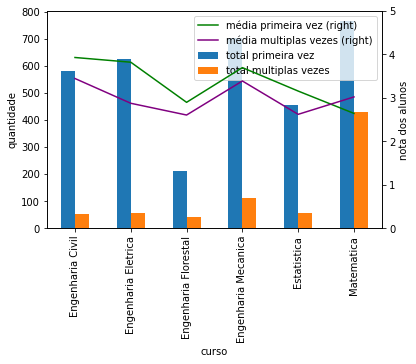

In [45]:
ax = plotdata[["média primeira vez", "média multiplas vezes"]].plot(secondary_y=True, rot=90, style=['green','purple'], ylabel="quantidade", xlabel="curso", legend="upper right")
plotdata[["total primeira vez", "total multiplas vezes"]].plot(kind="bar", rot=90, ax = ax, ylabel="nota dos alunos", ylim=[0, 5])
# ax.set_xlabel("curso")
# ax.set_ylabel("quantidade")
# plt.legend(loc='upper left')


# Em qual semestre os alunos cursam a matéria

<AxesSubplot:xlabel='semestre', ylabel='quantidade'>

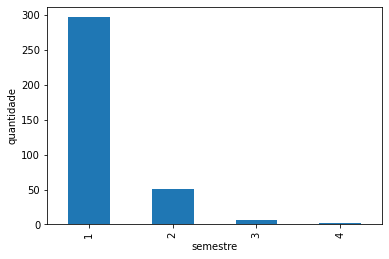

In [42]:
select_query = "select student_semester, count(*) as COUNT from students as S INNER JOIN student_course_subject as SCS ON S.id = SCS.id_student INNER JOIN subjects as Sub ON Sub.id = SCS.id_subject INNER JOIN student_courses as SC ON SC.id_student = S.id  where " + whereClause + where1 + "group by student_semester"
cursor.execute(select_query)
records = pd.DataFrame(cursor.fetchall())
records.columns = cursor.column_names

series = records['COUNT'].squeeze()
series.index = records['student_semester'].tolist()
series = series.sort_index()

series.plot.bar(ylabel="quantidade", xlabel="semestre")

# Quantas vezes os alunos cursam a matéria

In [43]:
select_query = "select COUNT from (select id_student, count(*) as COUNT from students as st inner join student_course_subject as SCS on st.id = SCS.id_student INNER JOIN subjects as S on S.id = SCS.id_subject where" + whereClause + "group by id_student order by COUNT DESC) count_table"

cursor.execute(select_query)
records = pd.DataFrame(cursor.fetchall())
records.columns = cursor.column_names

fig = px.treemap(
    records, path=['COUNT']
)
fig.show()